# **1. Library Loading**

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# **2. Preparing the Dataset**

In [2]:
from sklearn.datasets import load_digits

# import dataset
X, y = load_digits(return_X_y=True)

# Validate
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (1797, 64)
y shape: (1797,)


- Splitting the data into train, valid, and test set.

In [3]:
from sklearn.model_selection import train_test_split

# Split train & (valid and test) --> 80:20
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

# Split valid & test --> 50:50
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test,
    y_test,
    stratify=y_test,
    test_size=0.5,
    random_state=42
)

# Validate
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X valid shape:', X_valid.shape)
print('y valid shape:', y_valid.shape)
print('X test shape :', X_test.shape)
print('y test shape :', y_test.shape)

X train shape: (1437, 64)
y train shape: (1437,)
X valid shape: (180, 64)
y valid shape: (180,)
X test shape : (180, 64)
y test shape : (180,)


In [4]:
# Convert to torch tensor
X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
X_valid, y_valid = torch.tensor(X_valid), torch.tensor(y_valid)
X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)

# **3. Create a Comparison Function**

- Creating a utility function to compare manual gradients to PyTorch gradients.
- The function is to check whether the results we calculate from scratch are the same with calculation from PyTorch library.

In [5]:
# Defining function for comparing gradients
def compare_grad(element, manual_grad, torch_node):
    """comparing manual gradients to PyTorch gradients"""
    # Extract gradients
    torch_grad = torch_node.grad

    # Exact comparison
    exact = torch.all(manual_grad == torch_grad).item()

    # Approximate comparison
    apprx = torch.allclose(manual_grad, torch_grad)

    # Calculate maximum different between manual and torch gradients
    max_diff = (
        (manual_grad-torch_grad)    # calculate the difference
        .abs()                      # then take the absolute value
        .max()                      # and find the maximum value of it
        .item()
    )

    # Print
    print(f'{element:15s} | exact: {str(exact):5s} | approximate: {str(apprx):5s} | max diff.: {max_diff}')

# **4. Creating the Neural Network using PyTorch**

- Creating a neural network to classify the digits.
- The architectures are
  - Having 64 input dimensions
  - Having 2 layers (1 hidden layer and 1 output layer)
  - The output layer has 10 neurons (1 neuron for each digits)

In [6]:
# Defining the size
n_in = 64
n_hidden = 24
n_out = 10

In [7]:
# Create the Neural Network
g = torch.Generator().manual_seed(42)

# Layer 1 (The hidden layer)
W1 = torch.randn((n_in, n_hidden),  generator=g, dtype=torch.float64) * (5/3) / (n_in**0.5)
b1 = torch.randn(n_hidden,          generator=g, dtype=torch.float64) * 0.1

# Layer 2 (The output layer)
W2 = torch.randn((n_hidden, n_out), generator=g, dtype=torch.float64) * 0.1
b2 = torch.randn(n_out,             generator=g, dtype=torch.float64) * 0.1

# Get the parameters
parameters = [W1, b1, W2, b2]
print(sum(param.nelement() for param in parameters))

# Activate the grad
for param in parameters:
    param.requires_grad = True

1810


- Creating a single forward pass that we want to calculate its gradients manually.

<center>
<img src="https://drive.google.com/uc?id=1_LiahYJt_Ij-zjCE1RcHCEe2jiDxUXI-">

In [8]:
# Create a batch learning
batch_size = 32
n = batch_size

# Construct a minibatch
mini_ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
X_batch, y_batch = X_train[mini_ix], y_train[mini_ix]

# Validating data
print('X_batch shape:', X_batch.shape)
print('y_batch shape:', y_batch.shape)

X_batch shape: torch.Size([32, 64])
y_batch shape: torch.Size([32])


In [9]:
# Performing a forward pass

# The first hidden layer calculation
h_pre_act = X_batch @ W1 + b1

# Performing a non-linearity calculation (activation function)
h = torch.tanh(h_pre_act)

# The second and output layer
logits = h @ W2 + b2

# Calculating loss
counts = logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
log_probs = probs.log()
loss = -log_probs[range(n), y_batch].mean()

# Performing the backward pass with PyTorch
for p in parameters:
    p.grad = None

for p in [log_probs, probs, counts_sum_inv, counts_sum, counts,
          logits, h, h_pre_act]:
    p.retain_grad()

loss.backward()
loss

tensor(2.3850, dtype=torch.float64, grad_fn=<NegBackward0>)

# **5. Performing Backpropagation for `counts`, `counts_sum`, and `counts_sum_inv`**

- We need to find :

$$
\cfrac
{\partial \ \text{loss}}
{\partial \ \text{counts}}
$$

$$
\cfrac
{\partial \ \text{loss}}
{\partial \ \text{counts_sum}}
$$

$$
\cfrac
{\partial \ \text{loss}}
{\partial \ \text{counts_sum_inv}}
$$

- In graph :

<center>
<img src="https://drive.google.com/uc?id=1ehlVs8Ol9-VILS-ogqaOaS8NLxNIvXcT">

## 5.1 Calculating the `counst_sum_inv`

- From the graph, `counts` derivative is come from `probs` and `counts_sum`
- We can find the `counts` derivative step by step, start from the `counts_sum_inv`


- We can use the equation :
```
probs = counts * counts_sum_inv
dprobs = counts dcounts_sum_inv
```

- Thus :
```
dloss/dcounts_sum_inv = counts * dprobs
```

In [10]:
dlog_probs = torch.zeros_like(log_probs)
dlog_probs[range(n), y_batch] = -1.0 / n
dprobs = (1./probs) * dlog_probs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)

# Check the comparison between manual & automatic gradients
compare_grad('log_probs', dlog_probs, log_probs)
compare_grad('probs', dprobs, probs)
compare_grad('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

log_probs       | exact: True  | approximate: True  | max diff.: 0.0
probs           | exact: True  | approximate: True  | max diff.: 0.0
counts_sum_inv  | exact: True  | approximate: True  | max diff.: 0.0


## 5.2. Calculate the `counst_sum`

- Then we can find the derivative of `loss` to the `counts_sum`

- We can use the equation :
```
counts_sum_inv = counts_sum**-1
dcounts_sum_inv = -1 * (counts_sum)**(-2)
```

- Thus :
```
dloss/dcounts_sum = counts * dcounts_sum_inv
```

In [11]:
# Calculating dcounts_sum
dcounts_sum = -1 * (counts_sum)**(-2) * dcounts_sum_inv

# Check the comparison between manual & automatic gradients
compare_grad('log_probs', dlog_probs, log_probs)
compare_grad('probs', dprobs, probs)
compare_grad('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
compare_grad('counts_sum', dcounts_sum, counts_sum)

log_probs       | exact: True  | approximate: True  | max diff.: 0.0
probs           | exact: True  | approximate: True  | max diff.: 0.0
counts_sum_inv  | exact: True  | approximate: True  | max diff.: 0.0
counts_sum      | exact: True  | approximate: True  | max diff.: 0.0


## 5.3 Calculate the `counst`

- Finally, we can calculate the derivative of `loss` to `counts`
- Remember, there are two sources of gradient to the `counts` node, i.e. from `probs` and `counts_sum`

- We can use the equation
```
probs = counts * counts_sum_inv
dprobs = counts_sum_inv * dcounts
```

- Thus
```
dloss/dcounts = counts_sum_inv * dprobs
```

- Next, we can use the equation
```
counts_sum = counts.sum(1, keepdims=True)
dcounts_sum = 1. * dcounts
```

- Thus
```
dloss/dcounts = 1. * dcounts_sum
```

In [12]:
dcounts = counts_sum_inv * dprobs
dcounts += torch.ones_like(counts) * dcounts_sum

# Check the comparison between manual & automatic gradients
compare_grad('log_probs', dlog_probs, log_probs)
compare_grad('probs', dprobs, probs)
compare_grad('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
compare_grad('counts_sum', dcounts_sum, counts_sum)
compare_grad('counts', dcounts, counts)

log_probs       | exact: True  | approximate: True  | max diff.: 0.0
probs           | exact: True  | approximate: True  | max diff.: 0.0
counts_sum_inv  | exact: True  | approximate: True  | max diff.: 0.0
counts_sum      | exact: True  | approximate: True  | max diff.: 0.0
counts          | exact: True  | approximate: True  | max diff.: 0.0


# **6. Performing Backprop the `logits`**

- We need to find

$$
\cfrac
{\partial \ \text{loss}}
{\partial \ \text{logits}}
$$

- In graph :

<center>
<img src="https://drive.google.com/uc?id=1v4FqTiXVBT0E5wkF1ZFksYpUm8nijPEQ">

- We can use the equation
```
counts = exp(logits)
dcounts = exp(logits) dlogits
```

- Thus
```
dloss/dlogits = exp(logits) * dcounts
```

In [13]:
dlogits = counts * dcounts

# Check the comparison between manual & automatic gradients
compare_grad('log_probs', dlog_probs, log_probs)
compare_grad('probs', dprobs, probs)
compare_grad('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
compare_grad('counts_sum', dcounts_sum, counts_sum)
compare_grad('counts', dcounts, counts)
compare_grad('logits', dlogits, logits)

log_probs       | exact: True  | approximate: True  | max diff.: 0.0
probs           | exact: True  | approximate: True  | max diff.: 0.0
counts_sum_inv  | exact: True  | approximate: True  | max diff.: 0.0
counts_sum      | exact: True  | approximate: True  | max diff.: 0.0
counts          | exact: True  | approximate: True  | max diff.: 0.0
logits          | exact: True  | approximate: True  | max diff.: 0.0


# **7. Performing Backpropagation for `W2`, `b2`, and `h`**

- Here I try to find the parameters for second layer.

- We need to find :

$$
\cfrac
{\partial \ \text{loss}}
{\partial \ \text{W2}}
$$

$$
\cfrac
{\partial \ \text{loss}}
{\partial \ \text{h2}}
$$

$$
\cfrac
{\partial \ \text{loss}}
{\partial \ \text{h}}
$$

- In graph :

<center>
<img src="https://drive.google.com/uc?id=1c8c2jyWPyWQC_nqGmk2ifb-hpIWyALKN">

- We can use the equation
```
logits = h @ W2 + b2
dlogits = W2 dh
dlogits = 1 db2
dlogits = h dW2
```

- Thus
```
dloss/dW2 = h * dlogits
dloss/dh = W2 * dlogits
dloss/db2 = 1 * dlogits
```

- In details, let :

$$
d = h \cdot w + c
$$

$$
\begin{bmatrix}
d_{11} & d_{12} & d_{13}\\
d_{21} & d_{22} & d_{23}
\end{bmatrix}
=
\begin{bmatrix}
h_{11} & h_{12}\\
h_{21} & h_{22}
\end{bmatrix}
\cdot
\begin{bmatrix}
w_{11} & w_{12} & w_{13}\\
w_{21} & w_{22} & w_{23}
\end{bmatrix}
+
\begin{bmatrix}
c_{1} & c_{2} & c_{3}\\
c_{1} & c_{2} & c_{3}
\end{bmatrix}
$$

$$
\begin{align*}
d_{11} &= h_{11}w_{11} + h_{12}w_{21} + c_{1} \\
d_{12} &= h_{11}w_{12} + h_{12}w_{22} + c_{2} \\
d_{13} &= h_{11}w_{13} + h_{12}w_{23} + c_{3} \\
d_{21} &= h_{21}w_{11} + h_{22}w_{21} + c_{1} \\
d_{22} &= h_{21}w_{12} + h_{22}w_{22} + c_{2} \\
d_{23} &= h_{21}w_{13} + h_{22}w_{23} + c_{3} \\
\end{align*}
$$

- So, we can find the derivative of loss with respect to model parameters.

$$
\begin{align*}
\cfrac{\partial L}{\partial w_{11}} &= \cfrac{\partial L}{\partial d_{11}} \cdot h_{11} + \cfrac{\partial L}{\partial d_{21}} \cdot h_{21} \\
\cfrac{\partial L}{\partial w_{12}} &= \cfrac{\partial L}{\partial d_{12}} \cdot h_{11} + \cfrac{\partial L}{\partial d_{22}} \cdot h_{21} \\
\cfrac{\partial L}{\partial w_{13}} &= \cfrac{\partial L}{\partial d_{13}} \cdot h_{11} + \cfrac{\partial L}{\partial d_{23}} \cdot h_{21} \\
\cfrac{\partial L}{\partial w_{21}} &= \cfrac{\partial L}{\partial d_{11}} \cdot h_{12} + \cfrac{\partial L}{\partial d_{21}} \cdot h_{22} \\
\cfrac{\partial L}{\partial w_{22}} &= \cfrac{\partial L}{\partial d_{12}} \cdot h_{12} + \cfrac{\partial L}{\partial d_{22}} \cdot h_{22} \\
\cfrac{\partial L}{\partial w_{23}} &= \cfrac{\partial L}{\partial d_{13}} \cdot h_{12} + \cfrac{\partial L}{\partial d_{23}} \cdot h_{22}
\end{align*}
$$

$$
\begin{align*}
\begin{bmatrix}
\cfrac{\partial L}{\partial w_{11}} & \cfrac{\partial L}{\partial w_{12}} & \cfrac{\partial L}{\partial w_{13}}\\
\cfrac{\partial L}{\partial w_{21}} & \cfrac{\partial L}{\partial w_{22}} & \cfrac{\partial L}{\partial w_{23}}
\end{bmatrix}
&=
\begin{bmatrix}
h_{11} & h_{21}\\
h_{12} & h_{22}
\end{bmatrix}
\cdot
\begin{bmatrix}
\cfrac{\partial L}{\partial d_{11}} & \cfrac{\partial L}{\partial d_{12}} & \cfrac{\partial L}{\partial d_{13}}\\
\cfrac{\partial L}{\partial d_{21}} & \cfrac{\partial L}{\partial d_{22}} & \cfrac{\partial L}{\partial d_{23}}
\end{bmatrix}\\
\cfrac{\partial L}{\partial W} &= h^{T} \cdot \cfrac{\partial L}{\partial d}
\end{align*}
$$

- With similar way, we got :

$$
\cfrac{\partial L}{\partial h} = \cfrac{\partial L}{\partial d} \cdot W^{T}
$$

- For the bias :

$$
\begin{align*}
\cfrac{\partial L}{\partial c_{1}} &= \cfrac{\partial L}{\partial d_{11}} \cdot 1.0 + \cfrac{\partial L}{\partial d_{21}} \cdot 1.0 \\
\cfrac{\partial L}{\partial c_{2}} &= \cfrac{\partial L}{\partial d_{12}} \cdot 1.0 + \cfrac{\partial L}{\partial d_{22}} \cdot 1.0 \\
\cfrac{\partial L}{\partial c_{3}} &= \cfrac{\partial L}{\partial d_{13}} \cdot 1.0 + \cfrac{\partial L}{\partial d_{23}} \cdot 1.0 \\
\end{align*}
$$

$$
\begin{align*}
\begin{bmatrix}
\cfrac{\partial L}{\partial c_{1}} & \cfrac{\partial L}{\partial c_{2}} & \cfrac{\partial L}{\partial c_{3}}\\
\end{bmatrix}
&=
\begin{bmatrix}
1.0 & 1.0 & 1.0
\end{bmatrix}
\cdot
\begin{bmatrix}
\cfrac{\partial L}{\partial d_{11}} & \cfrac{\partial L}{\partial d_{12}} & \cfrac{\partial L}{\partial d_{13}}\\
\cfrac{\partial L}{\partial d_{21}} & \cfrac{\partial L}{\partial d_{22}} & \cfrac{\partial L}{\partial d_{23}}
\end{bmatrix}\\
\cfrac{\partial L}{\partial c} &= \begin{bmatrix}
1.0 & 1.0 & 1.0
\end{bmatrix}
\cdot
\cfrac{\partial L}{\partial d}
\end{align*}
$$

In [14]:
dlog_probs = torch.zeros_like(log_probs)
dlog_probs[range(n), y_batch] = -1.0 / n
dprobs = (1./probs) * dlog_probs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts_sum = -1 * (counts_sum)**(-2) * dcounts_sum_inv
dcounts = counts_sum_inv * dprobs
dcounts += torch.ones_like(counts) * dcounts_sum
dlogits = counts * dcounts

# Write the code here
dW2 = h.T @ dlogits
dh = dlogits @ W2.T
db2 = dlogits.sum(0)  # add along the columns (neurons)

In [15]:
# Check the comparison between manual & automatic gradients
compare_grad('log_probs', dlog_probs, log_probs)
compare_grad('probs', dprobs, probs)
compare_grad('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
compare_grad('counts_sum', dcounts_sum, counts_sum)
compare_grad('counts', dcounts, counts)
compare_grad('logits', dlogits, logits)
compare_grad('W2', dW2, W2)
compare_grad('h', dh, h)
compare_grad('b2', db2, b2)

log_probs       | exact: True  | approximate: True  | max diff.: 0.0
probs           | exact: True  | approximate: True  | max diff.: 0.0
counts_sum_inv  | exact: True  | approximate: True  | max diff.: 0.0
counts_sum      | exact: True  | approximate: True  | max diff.: 0.0
counts          | exact: True  | approximate: True  | max diff.: 0.0
logits          | exact: True  | approximate: True  | max diff.: 0.0
W2              | exact: True  | approximate: True  | max diff.: 0.0
h               | exact: True  | approximate: True  | max diff.: 0.0
b2              | exact: True  | approximate: True  | max diff.: 0.0


# **8. Performing Backpropagation for `W1` and `b1`**

- Here we try to calculate the parameters in the first layer.

- We need to find

$$
\cfrac
{\partial \ \text{loss}}
{\partial \ \text{W1}}
$$

$$
\cfrac
{\partial \ \text{loss}}
{\partial \ \text{b1}}
$$

- In graph :

<center>
<img src="https://drive.google.com/uc?id=1a3NSCtenXUFHU9Z3AA7EEG7GFt1PadMZ">

- We can use the equation as follow :
```
h_pre_act = X @ W1 + b1
dh_pre_act = X dW1
dh_pre_act = 1 b1
```

- Thus :
```
dloss/dW1 = X * dh_pre_act
dloss/db1 = 1 * dh_pre_act
```

In [16]:
dlog_probs = torch.zeros_like(log_probs)
dlog_probs[range(n), y_batch] = -1.0 / n
dprobs = (1./probs) * dlog_probs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts_sum = -1 * (counts_sum)**(-2) * dcounts_sum_inv
dcounts = counts_sum_inv * dprobs
dcounts += torch.ones_like(counts) * dcounts_sum
dlogits = counts * dcounts
dW2 = h.T @ dlogits
dh = dlogits @ W2.T
db2 = dlogits.sum(0)
dh_pre_act = (1 - h**2) * dh

# Write the code here
dW1 = X_batch.T @ dh_pre_act
db1 = dh_pre_act.sum(0)

In [17]:
# Check the comparison between manual & automatic gradients
compare_grad('log_probs', dlog_probs, log_probs)
compare_grad('probs', dprobs, probs)
compare_grad('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
compare_grad('counts_sum', dcounts_sum, counts_sum)
compare_grad('counts', dcounts, counts)
compare_grad('logits', dlogits, logits)
compare_grad('W2', dW2, W2)
compare_grad('h', dh, h)
compare_grad('b2', db2, b2)
compare_grad('h_pre_act', dh_pre_act, h_pre_act)
compare_grad('W1', dW1, W1)
compare_grad('b1', db1, b1)

log_probs       | exact: True  | approximate: True  | max diff.: 0.0
probs           | exact: True  | approximate: True  | max diff.: 0.0
counts_sum_inv  | exact: True  | approximate: True  | max diff.: 0.0
counts_sum      | exact: True  | approximate: True  | max diff.: 0.0
counts          | exact: True  | approximate: True  | max diff.: 0.0
logits          | exact: True  | approximate: True  | max diff.: 0.0
W2              | exact: True  | approximate: True  | max diff.: 0.0
h               | exact: True  | approximate: True  | max diff.: 0.0
b2              | exact: True  | approximate: True  | max diff.: 0.0
h_pre_act       | exact: False | approximate: True  | max diff.: 4.336808689942018e-19
W1              | exact: False | approximate: True  | max diff.: 4.163336342344337e-17
b1              | exact: False | approximate: True  | max diff.: 2.6020852139652106e-18


# **9. Backpropagation the `h_pre_act`**

- Here we try to find the parameter of h before performed with activation function.

- We need to find

$$
\cfrac
{\partial \ \text{loss}}
{\partial \ \text{h_pre_act}}
$$

- In graph

<center>
<img src="https://drive.google.com/uc?id=1zaovirepV51QS0nS9lJVntb85Lf4tZQ_">

- We can use the equation :
```
h = tanh(h_pre_act)
dh = (1 - tanh(h_pre_act)**2) dh_pre_act
```

- Thus :
```
dloss/dh_pre_act = (1 - tanh(h_pre_act)**2) * dh
```

In [18]:
dlog_probs = torch.zeros_like(log_probs)
dlog_probs[range(n), y_batch] = -1.0 / n
dprobs = (1./probs) * dlog_probs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts_sum = -1 * (counts_sum)**(-2) * dcounts_sum_inv
dcounts = counts_sum_inv * dprobs
dcounts += torch.ones_like(counts) * dcounts_sum
dlogits = counts * dcounts
dW2 = h.T @ dlogits
dh = dlogits @ W2.T
db2 = dlogits.sum(0)

# Write the code here
dh_pre_act = (1 - h**2) * dh

In [19]:
# Check the comparison between manual & automatic gradients
compare_grad('log_probs', dlog_probs, log_probs)
compare_grad('probs', dprobs, probs)
compare_grad('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
compare_grad('counts_sum', dcounts_sum, counts_sum)
compare_grad('counts', dcounts, counts)
compare_grad('logits', dlogits, logits)
compare_grad('W2', dW2, W2)
compare_grad('h', dh, h)
compare_grad('b2', db2, b2)
compare_grad('h_pre_act', dh_pre_act, h_pre_act)

log_probs       | exact: True  | approximate: True  | max diff.: 0.0
probs           | exact: True  | approximate: True  | max diff.: 0.0
counts_sum_inv  | exact: True  | approximate: True  | max diff.: 0.0
counts_sum      | exact: True  | approximate: True  | max diff.: 0.0
counts          | exact: True  | approximate: True  | max diff.: 0.0
logits          | exact: True  | approximate: True  | max diff.: 0.0
W2              | exact: True  | approximate: True  | max diff.: 0.0
h               | exact: True  | approximate: True  | max diff.: 0.0
b2              | exact: True  | approximate: True  | max diff.: 0.0
h_pre_act       | exact: False | approximate: True  | max diff.: 4.336808689942018e-19


# **10. Train with manual backpropagation**

- First, reinitialize the weights

In [20]:
# Create the Neural Network
g = torch.Generator().manual_seed(42)

# Layer 1 (The hidden layer)
W1 = torch.randn((n_in, n_hidden),  generator=g, dtype=torch.float64) * (5/3) / (n_in**0.5)
b1 = torch.randn(n_hidden,          generator=g, dtype=torch.float64) * 0.1

# Layer 2 (The output layer)
W2 = torch.randn((n_hidden, n_out), generator=g, dtype=torch.float64) * 0.1
b2 = torch.randn(n_out,             generator=g, dtype=torch.float64) * 0.1

# Get the parameters
parameters = [W1, b1, W2, b2]
print(sum(param.nelement() for param in parameters))

# Activate the grad
for param in parameters:
    param.requires_grad = True

1810


- Train the NN model

In [21]:
max_steps = 100_000
batch_size = 32
n = batch_size
losses = []

# We will calculate the grad manually
with torch.no_grad():

    # Start optimizing
    for i in range(max_steps):
        # Construct a minibatch
        mini_ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
        X_batch, y_batch = X_train[mini_ix], y_train[mini_ix]

        # Perform the forward pass
        h_pre_act = X_batch @ W1 + b1
        h = torch.tanh(h_pre_act)
        logits = h @ W2 + b2

        # Calculate loss
        counts = logits.exp()
        counts_sum = counts.sum(1, keepdims=True)
        counts_sum_inv = counts_sum**-1
        probs = counts * counts_sum_inv
        log_probs = probs.log()
        loss = -log_probs[range(n), y_batch].mean()

        # Let's do the backward pass
        for p in parameters:
            p.grad = None

        # Let's manually calculate the gradients
        dlog_probs = torch.zeros_like(log_probs)
        dlog_probs[range(n), y_batch] = -1.0 / n
        dprobs = (1./probs) * dlog_probs
        dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
        dcounts_sum = -1 * (counts_sum)**(-2) * dcounts_sum_inv
        dcounts = counts_sum_inv * dprobs
        dcounts += torch.ones_like(counts) * dcounts_sum
        dlogits = counts * dcounts
        dW2 = h.T @ dlogits
        dh = dlogits @ W2.T
        db2 = dlogits.sum(0)
        dh_pre_act = (1 - h**2) * dh
        dW1 = X_batch.T @ dh_pre_act
        db1 = dh_pre_act.sum(0)
        grads = [dW1, db1, dW2, db2]  # store the grads of our model parameters

        # Update the model parameters
        lr = 0.05 if i < 50_000 else 0.001
        for p, grad in zip(parameters, grads):
            p.data += -lr * grad

        # Track
        if i%10000 == 0:
            print(f'{i:8d}/{max_steps:8d}: {loss.item():.4f}')
        losses.append(loss.log().item())

       0/  100000: 2.3850
   10000/  100000: 0.0052
   20000/  100000: 0.0035
   30000/  100000: 0.0017
   40000/  100000: 0.0020
   50000/  100000: 0.0013
   60000/  100000: 0.0010
   70000/  100000: 0.0028
   80000/  100000: 0.0017
   90000/  100000: 0.0007


# **11. Model Evaluation**

In [22]:
@torch.no_grad()
def check_loss(split):
    X, y = {
    'train': (X_train, y_train),
    'valid': (X_valid, y_valid),
    'test': (X_test, y_test),
    }[split]

    # Perform a forward pass
    h_pre_act = X @ W1 + b1
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)

    print(split, loss.item())

check_loss('train')
check_loss('valid')

train 0.001800913632289739
valid 0.14544663165366303


# **12. Make predictions**

In [23]:
@torch.no_grad()
def predict(split):
    X, y = {
    'train': (X_train, y_train),
    'valid': (X_valid, y_valid),
    'test': (X_test, y_test),
    }[split]

    # Perform a forward pass
    h_pre_act = X @ W1 + b1
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    y_pred = probs.max(1).indices
    y_pred_proba = probs.max(1).values

    return y_pred, y_pred_proba

y_test_pred, y_test_pred_proba = predict('test')

- Plotting the predictions

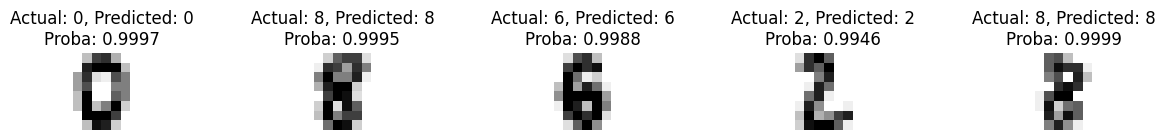

In [24]:
# plot
ix = torch.randint(0, X_test.shape[0], (5,))
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 1))
for ax, img, act, pred, proba in zip(axes, X_test[ix], y_test[ix], y_test_pred[ix], y_test_pred_proba[ix]):
    ax.set_axis_off()
    ax.imshow(img.reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Actual: {act}, Predicted: {pred}\nProba: {proba:.4f}', fontsize=12)